In [1]:
import pandas as pd

df_kaon = pd.read_csv('data/v1_kaon_train.csv')
df_kaon.head()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
0,733.720825,7811.620117,40.0,321,5.395000,5.395000,-2.7621,5.395000,-6.4719,3.056173
1,766.389587,13805.900391,29.0,321,32.001301,48.601002,-4.4894,32.001301,-11.0133,3.583537
2,454.289093,4635.049805,32.0,321,17.493500,17.493500,-12.2938,17.493500,-7.7980,3.013405
3,1054.564331,4333.899902,26.0,321,19.676600,19.676600,-7.5441,19.676600,-11.6452,2.091345
4,1975.175537,24745.910156,57.0,-321,20.518400,52.582600,0.0612,10.397500,0.0172,3.219554


In [2]:
x_cols = ['TrackPt', 'TrackP','TrackEta']
y_cols = ['RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe']

In [3]:
df_kaon[x_cols].shape, df_kaon[y_cols].shape

((999993, 3), (999993, 5))

In [4]:
import torch

latent_dims = 64
dropout_rate = 0.1

generator = torch.nn.Sequential(
    torch.nn.Linear(latent_dims, 128),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(128, 256),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(256, 512),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(512, 5),
    torch.nn.Tanh()
)#.cuda()

critic = torch.nn.Sequential(
    torch.nn.Linear(5, 512),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(256, 1),
)#.cuda()

In [5]:
LR = 0.00005
N_EPOCHS = 300
N_CRITIC_STEPS = 5
CLAMP = 0.01

In [6]:
def generator_loss(fake):
    return -torch.mean(critic(fake))
  
def critic_loss(real, fake):
    return torch.mean(critic(fake))-torch.mean(critic(real))

batch_size = 32

def sample_responses(batch_size):
    ids = np.random.choice(len(df_kaon), size=batch_size)
    return torch.tensor(np.array(df_kaon[y_cols])[ids])#.cuda()

def sample_fake(batch_size):
    noise = torch.randn(batch_size, latent_dims)#.cuda()
    return generator(noise)

generator_losses = []
critic_losses = []

critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LR)
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LR)

In [7]:
import torch.utils.data

data_loader = torch.utils.data.DataLoader(dataset=df_kaon[y_cols],
                                          batch_size=batch_size, 
                                          shuffle=True)

In [8]:
len(data_loader)

31250

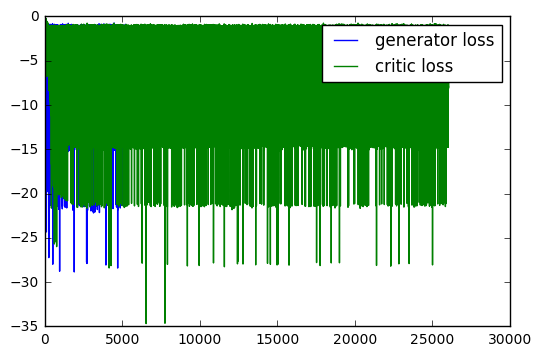

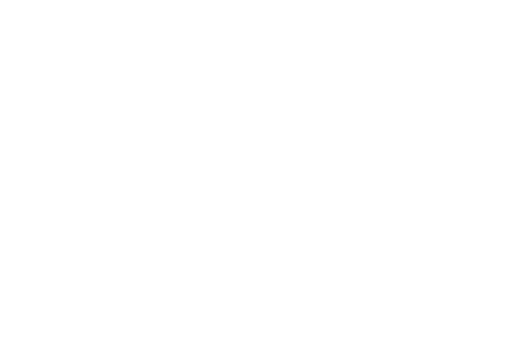

Training ended early.


In [9]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

try: 
    for epoch in range(N_EPOCHS):

        crit_steps = 0
        
        for i in range(len(data_loader)):
            real = sample_responses(batch_size)
            fake = sample_fake(batch_size)
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)
                
                cr_loss = critic_loss(real.float(), fake.float())
                cr_loss.backward()
                critic_optimizer.step()
                crit_steps += 1
                #print(crit_steps)
                critic_losses.append(cr_loss.item())
            
            else:
                critic.zero_grad()
                generator.zero_grad()
                gen_loss = generator_loss(real.float())
                gen_loss.backward()
                generator_optimizer.step()
                crit_steps = 0
                generator_losses.append(gen_loss.item())
        if epoch % 20 == 0:
            clear_output(wait=True)
            plt.plot(generator_losses    , label='generator loss')
            plt.plot(critic_losses, label='critic loss')
            plt.legend()
            plt.show()
            generator.eval()
            plt.axis('off')
            plt.show()
except KeyboardInterrupt:
    print('Training ended early.')

In [10]:
#https://github.com/SiLiKhon/RICH_GAN_misc/blob/master/coopetition/scoring_program/score.py

def score_func(sample1, sample2):
    score = 0
    cols = sample1.columns
    w_normal = np.random.normal(size=(100, len(cols)))
    reference = sample1.copy()[cols].values
    #prediction = sample2.copy()[cols].values
    prediction = sample2.copy().values
    for k in range(100):
        score = max(score,
                    ks_2samp(
                        np.sum(w_normal[k] * reference, axis=1), 
                        np.sum(w_normal[k] * prediction, axis=1)
                    )[0]
                   )
    return score

# kaon

In [11]:
from sklearn.model_selection import KFold
from scipy.stats import ks_2samp

kf = KFold(n_splits=5)

model_scores = []
best_scores  = []

for train_index, test_index in kf.split(df_kaon[x_cols]):
    X_train = df_kaon[x_cols].iloc[train_index]
    Y_train = df_kaon[y_cols].iloc[train_index]
    X_test  = df_kaon[x_cols].iloc[test_index ]
    Y_test  = df_kaon[y_cols].iloc[test_index ]
  
    #model = Model()
    #model.train(X_train.copy(), Y_train.copy(), n_bins=5)
    Y_pred = sample_fake(len(X_test))#model.predict(X_test.copy())
    model_scores.append(score_func(Y_test, pd.DataFrame(Y_pred.detach().numpy())))
    best_scores.append(score_func(Y_test, Y_train))

In [12]:
Y_pred = pd.DataFrame(data=Y_pred.detach().numpy(), columns=y_cols) 

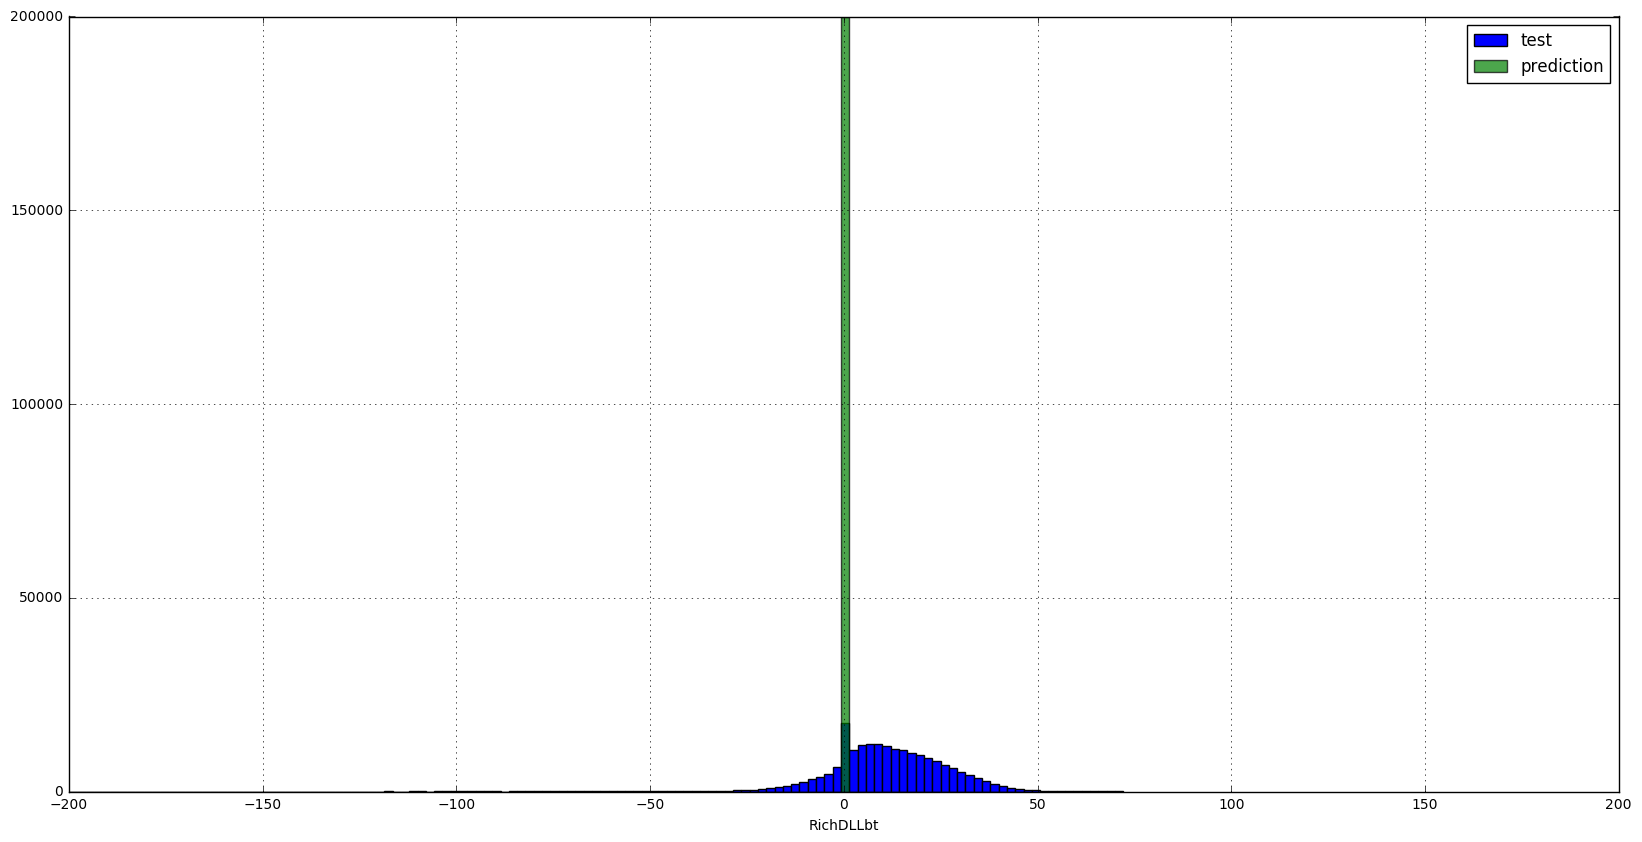

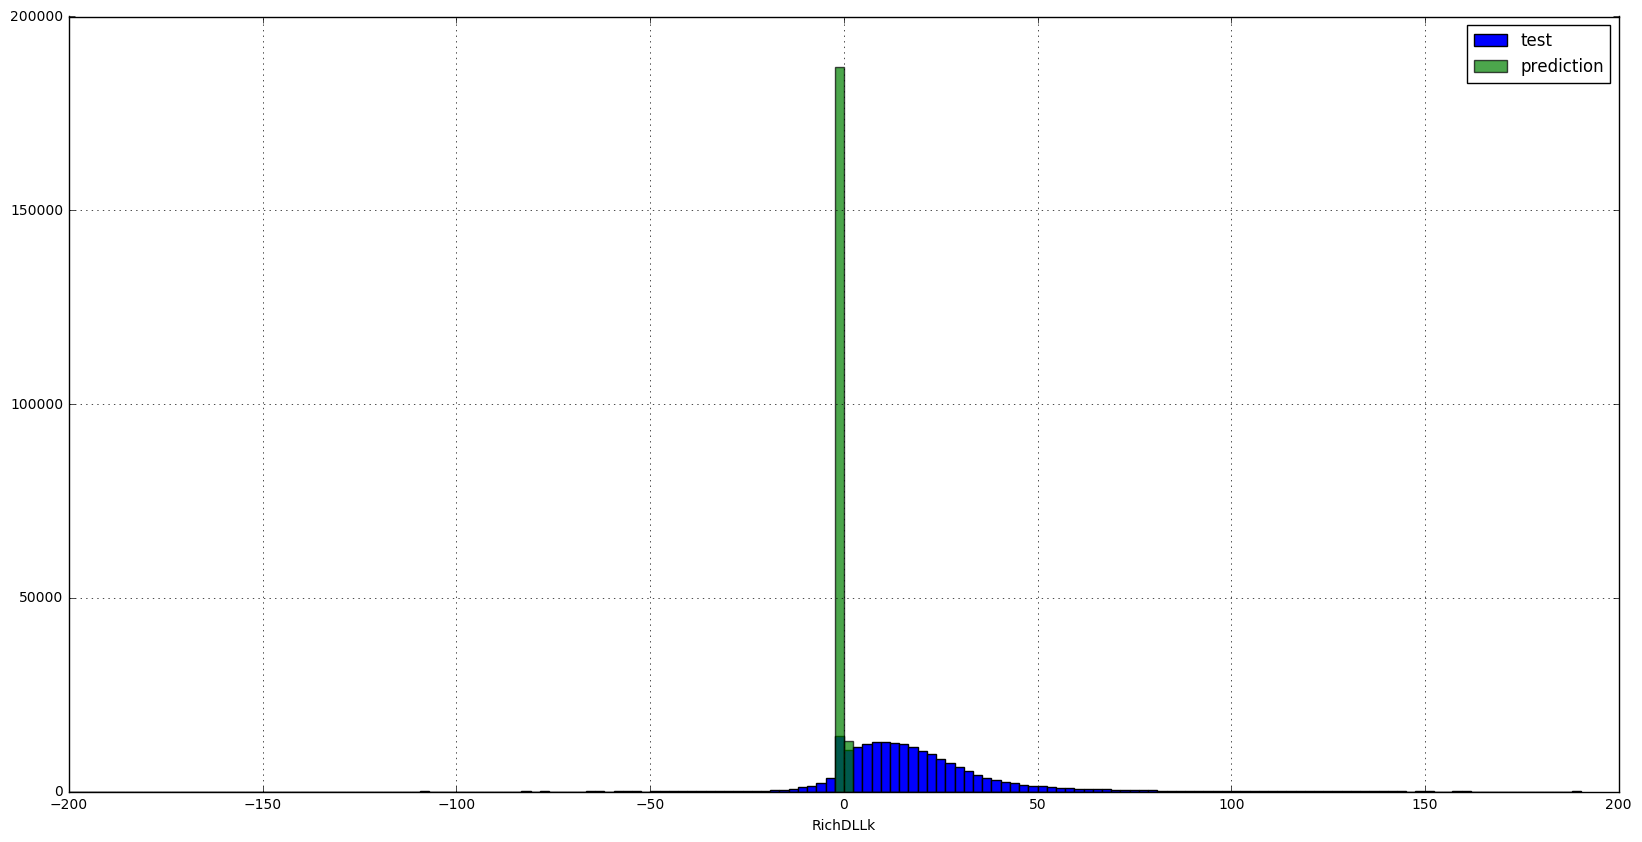

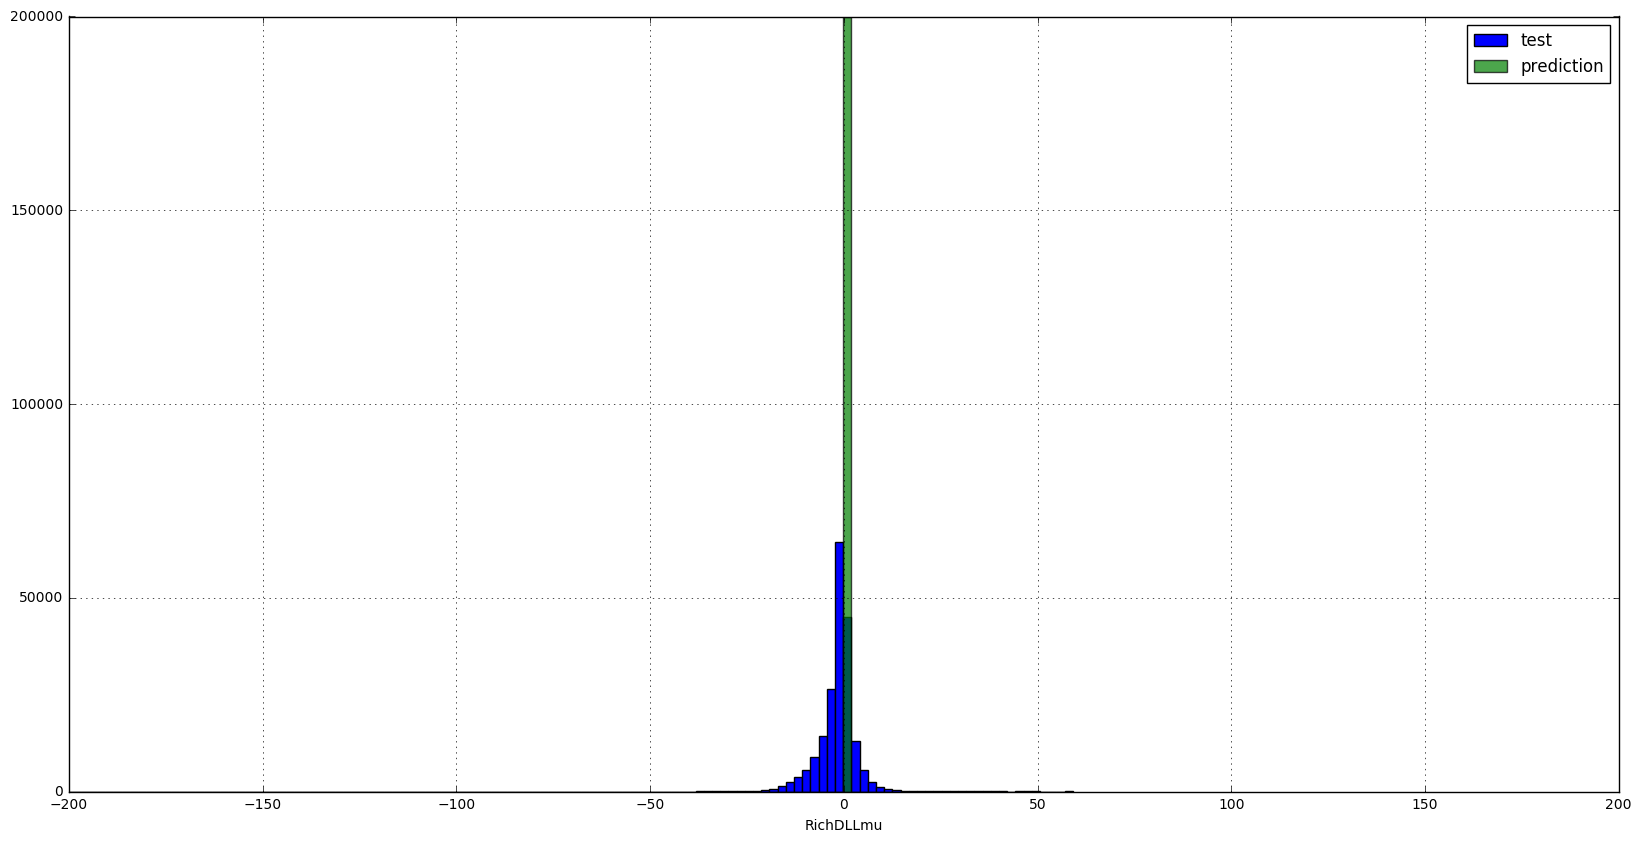

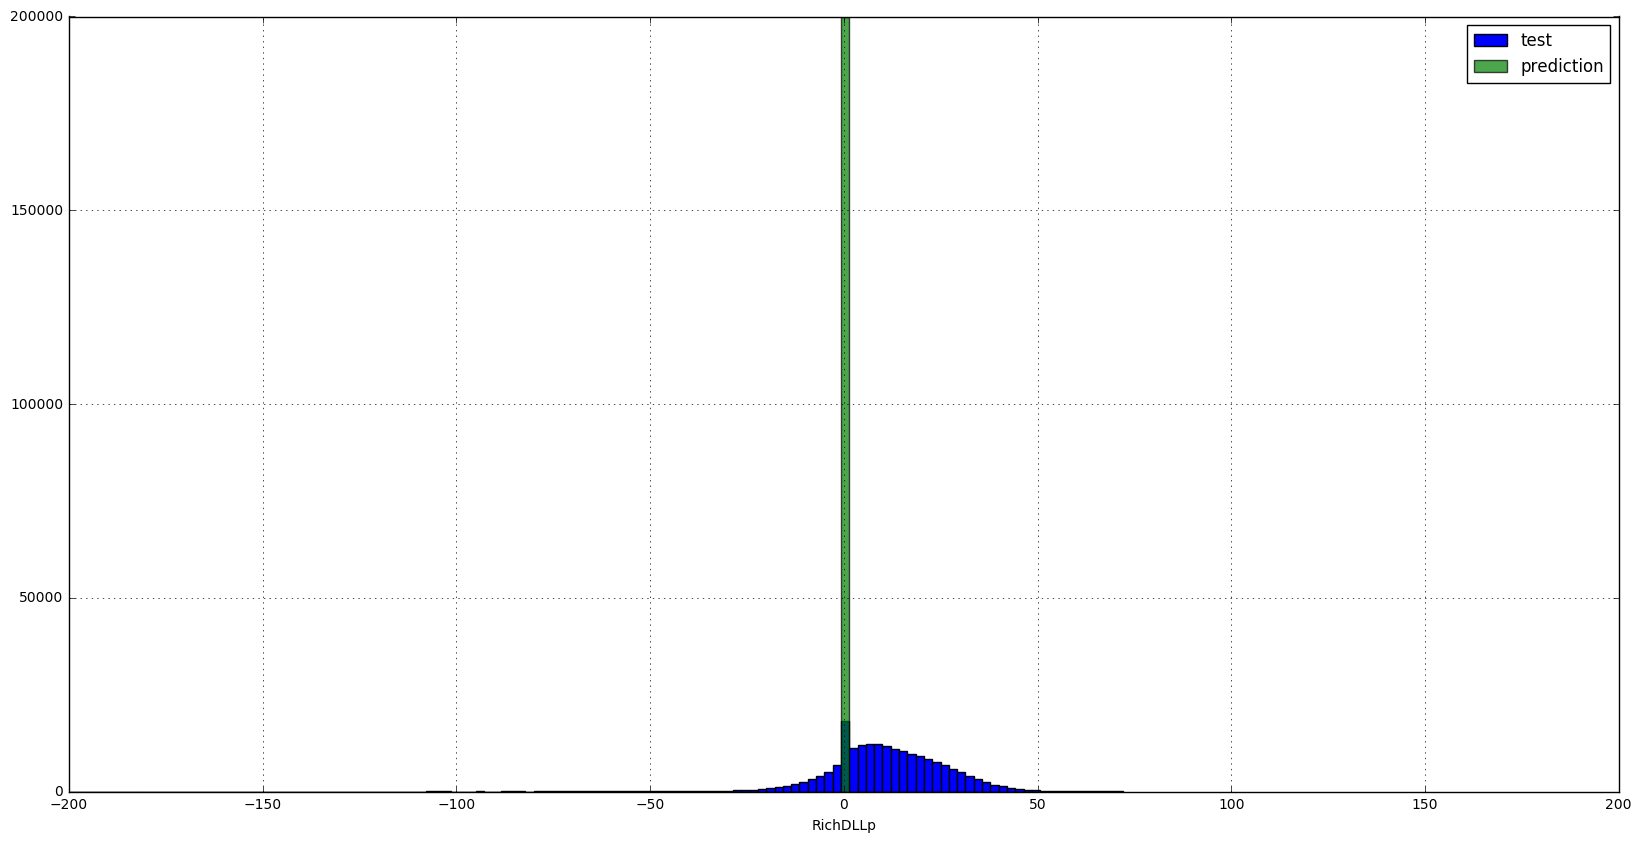

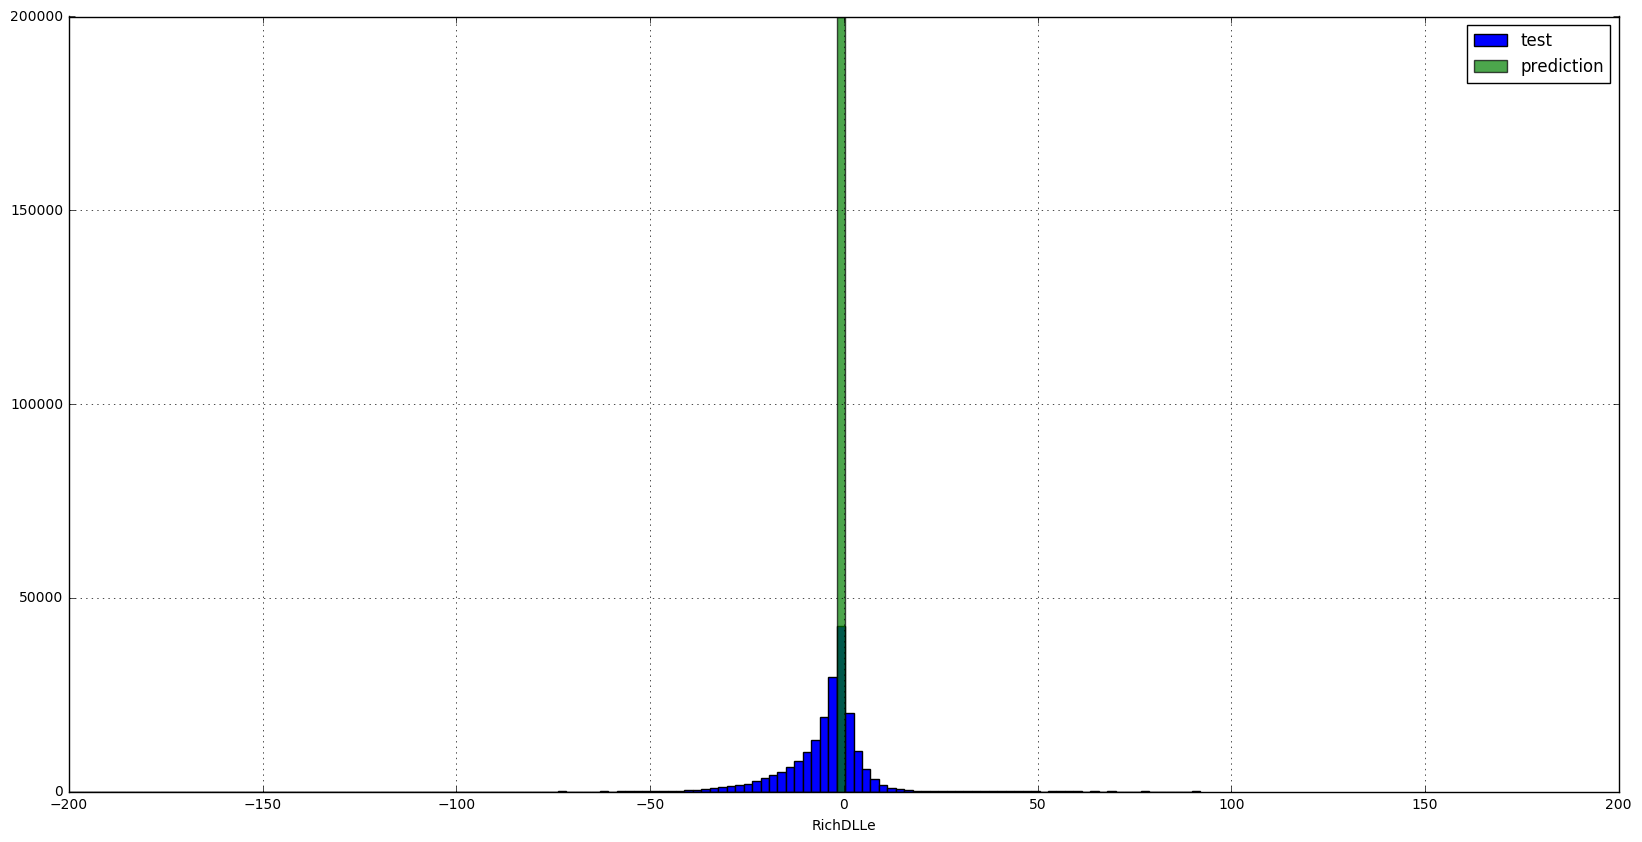

In [13]:
for col in Y_pred.columns:
    plt.subplots(figsize=(20, 10))
    plt.grid()
    _, bins, _ = plt.hist(Y_test[col], bins=500 , label='test'      )
    _, _   , _ = plt.hist(Y_pred[col], bins=bins, label='prediction', alpha=0.7)
    plt.legend(loc='best')
    plt.xlim(left=-200)
    plt.xlabel(col)
    plt.show();